In [59]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pandas as pd

from src.config import BLD

In [2]:
scenarios = {}
for scenario in [
    "spring_baseline",
    "spring_without_rapid_tests_and_no_vaccinations",
    "spring_without_vaccinations_without_seasonality",
    "spring_without_rapid_tests_without_seasonality",
    "spring_without_rapid_tests",
    "spring_without_vaccines",
    "spring_without_seasonality",
    "spring_no_effects",
]:
    scenarios[scenario] = pd.read_pickle(
        BLD
        / "simulations"
        / "time_series"
        / scenario
        / "full_newly_infected_weekly_incidence.pkl"
    )

In [3]:
df = {"name": [], "payoff": []}
for name, df_ in scenarios.items():
    df["name"].append(name)
    df["payoff"].append((scenarios[name].mean(axis=1)).sum())

df = pd.DataFrame(df)

In [4]:
df

,name,payoff
0,spring_baseline,26451.301344
1,spring_without_rapid_tests_and_no_vaccinations,76568.394624
2,spring_without_vaccinations_without_seasonality,56199.389438
3,spring_without_rapid_tests_without_seasonality,139692.328888
4,spring_without_rapid_tests,58280.057488
5,spring_without_vaccines,29353.482569
6,spring_without_seasonality,46288.145883
7,spring_no_effects,190042.173856


In [5]:
df["members"] = [
    frozenset(["rapid_tests", "vaccinations", "seasonality"]),
    frozenset(["seasonality"]),
    frozenset(["rapid_tests"]),
    frozenset(["vaccinations"]),
    frozenset(["vaccinations", "seasonality"]),
    frozenset(["rapid_tests", "seasonality"]),
    frozenset(["rapid_tests", "vaccinations"]),
    frozenset([]),
]

In [6]:
df["payoff"] = df["payoff"] - df["payoff"].max()

In [7]:
df

,name,payoff,members
0,spring_baseline,-163590.872512,"(rapid_tests, vaccinations, seasonality)"
1,spring_without_rapid_tests_and_no_vaccinations,-113473.779231,(seasonality)
2,spring_without_vaccinations_without_seasonality,-133842.784418,(rapid_tests)
3,spring_without_rapid_tests_without_seasonality,-50349.844968,(vaccinations)
4,spring_without_rapid_tests,-131762.116368,"(seasonality, vaccinations)"
5,spring_without_vaccines,-160688.691287,"(rapid_tests, seasonality)"
6,spring_without_seasonality,-143754.027973,"(rapid_tests, vaccinations)"
7,spring_no_effects,0.000000,()


In [8]:
from shapley import compute_shapley_values

In [9]:
shapley_values = compute_shapley_values(df)

In [10]:
ratios = shapley_values / shapley_values.sum()

In [11]:
shapley_values

shapley_value_rapid_tests    -78660.362697
shapley_value_seasonality    -62479.904302
shapley_value_vaccinations   -22450.605513
dtype: float64

In [12]:
ratios

shapley_value_rapid_tests     0.480836
shapley_value_seasonality     0.381928
shapley_value_vaccinations    0.137236
dtype: float64

In [19]:
plot_df = pd.DataFrame(
    {
        "baseline": scenarios["spring_baseline"].mean(axis=1),
        "no_effects": scenarios["spring_no_effects"].mean(axis=1),
    }
)

In [47]:
effects = ["vaccinations", "seasonality", "rapid_tests"]
for effect in effects:
    ratio = ratios.loc[f"shapley_value_{effect}"]
    plot_df[effect] = ratio * (plot_df["no_effects"] - plot_df["baseline"])

In [56]:
plot_df[effects] = plot_df[effects].cumsum(axis=1).add(plot_df["baseline"], axis=0)

<AxesSubplot:xlabel='date'>

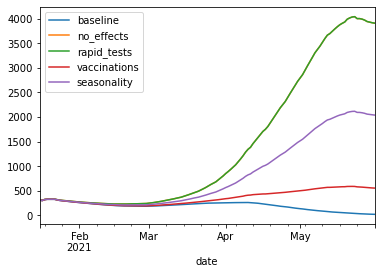

In [57]:
plot_df.plot()

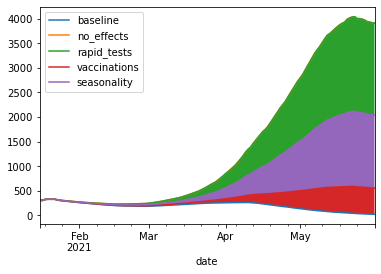

In [68]:
fig, ax = plt.subplots()

plot_df.plot(ax=ax)

plt.fill_between(
    plot_df.index, plot_df["seasonality"], plot_df["rapid_tests"], facecolor="C2"
)
plt.fill_between(
    plot_df.index, plot_df["vaccinations"], plot_df["seasonality"], facecolor="C4"
)
plt.fill_between(
    plot_df.index, plot_df["baseline"], plot_df["vaccinations"], facecolor="C3"
)

plt.show()
plt.close()